# Final Project Submission

Please fill out:
* Student name: Heath Rittler
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


# Introduction

## Business Case/ Summary

My business stakeholder is the owner of a local real estate agency.  The agency
focuses on home improvement recommendations to homeowners that will optimize the 
buying and selling of their homes.  I will be deciphering which home improvements
lead to the most value of a home.

## Data Summary

The dataset comes from King County, in Washington state.  The data in its raw form consists of 21 columns, and 21,597 records before any cleaning or feature engineering.  More information on the columns and definitions can be found in the repository here (data/column_names.md).  Any further information regarding the dataset can be found at the King County website (https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

# Data Load, Explore, & Cleaning

 ## Package load

In [424]:
# Importing packages for analysis

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
lr = LinearRegression()

plt.style.use('seaborn-talk')

%matplotlib inline

[(0.0, 0.0, 0.9352137256724836), (1.0, 0.9984636039674343, 1.0), (1.0, 0.11065268189150011, 0.031609044859322644), (0.0, 0.0, 0.0316090448593227), (0.0, 0.0, 1.0), (1.0, 0.9862007473534036, 0.9352137256724901)]


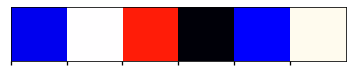

In [425]:
pal = sns.color_palette("flag_r")
print(pal)
sns.palplot(pal)

## Load

In [426]:
# Here we go!  Read csv, look at initial shape

df = pd.read_csv('data/kc_house_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [427]:
# Because my stakeholder and business proposition is recommending enhancements 
# for homeowners, I am going to remove the features that are not impactable by
# the hoemowner.  (i.e. Homeowner can't change the fact that they are or are not
# on waterfront) removing waterfront, view, lat, long, zipcode

df_clean = df.drop(
    ['waterfront', 'view', 'lat', 'long', 'zipcode'], axis=1)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 2.6+ MB


In [428]:
# Digging into object/ string fields to understand how we will transform.  First
# suspect is sqft_basement, would assume numeric values and 0 for no basement.

df_clean['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2500.0        1
906.0         1
207.0         1
2310.0        1
1525.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [429]:
# Changing basement sqft column.  Adjusting ? to 0.0, and changing data type
# to numeric in order to feed model.

df_clean['sqft_basement'] = df_clean['sqft_basement'].replace(['?'],'0.0')

df_clean['sqft_basement'].astype(float)

df_clean['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
2500.0        1
906.0         1
207.0         1
2310.0        1
1525.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [430]:
# Digging into yr_renovated

df_clean['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [431]:
# Not a ton of values, so going to add a boolean feature = is renovated

conditions = [df_clean.loc[:,'yr_renovated'] > 0,
              df_clean.loc[:,'yr_renovated'] == 0]

values = [1,0]

df_clean.loc[:,'is_renovated'] = np.select(conditions, values, default=0)

df_clean['is_renovated'].value_counts()

0    20853
1      744
Name: is_renovated, dtype: int64

In [432]:
# Adding another column with the count of years between yr built and renovation 'yr_frm_btr'

conditions = [
    (df_clean['yr_renovated'] == 0),
    (df_clean['yr_renovated'] > 0)
    ]

# create a list of the values we want to assign for each condition
values = [0, (df_clean['yr_renovated'] - df_clean['yr_built'])]

# create a new column and use np.select to assign values to it using our lists as arguments
df['yr_frm_btr'] = np.select(conditions, values)


In [433]:
# Dropping the yr_renovated column.  Don't necessarily need it right now

df_clean = df_clean.drop('yr_renovated', axis = 1)

In [434]:
# Another look again at info

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
 15  is_renovated   21597 non-null  int64  
dtypes: float64(3), int64(9), object(4)
memory usage: 2.6+ MB


<AxesSubplot:>

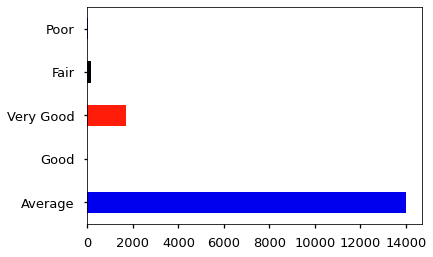

In [435]:
# checking out condition; will need to one hot encode these columns

df_clean['condition'].value_counts().plot(kind='barh', color=pal)

This breakdown is a little disappointing.  There really isn't a great distribution of condition.  Everything is listed as good, and above.  Going to look at grade to see if that
has a better distribution before encoding.

In [436]:
# checking out grade; going to strip string so we can make column numeric.

df_clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [437]:
# split column and add new columns to df
gd_sp = df_clean['grade'].str.split(' ', n = 1, expand = True)

# add column names
gd_sp.columns = ['grade_num', "grade_cat"]

# concat back to df_clean dataframe
df_clean = pd.concat([df_clean, gd_sp], axis = 1)

# update grade_num column to int datatype
df_clean['grade_num'] = df_clean['grade_num'].astype(int)

In [438]:
# dropping original column from dataframe
df_clean = df_clean.drop(['grade'], axis = 1)

# checking df_clean to see where we are at.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  is_renovated   21597 non-null  int64  
 15  grade_num      21597 non-null  int64  
 16  grade_cat      21597 non-null  object 
dtypes: float64(3), int64(10), object(4)
memory usage: 

In [439]:
# Adding some addtional features for fun; ratio of sq_ft above and floors;
# bedrooms amd bathrooms

In [440]:
# Adding ratio of above ground square footage to square footage of living area.  
# Trying to understand if their is more living square footage below ground, 
# is that attractive to a home buyer.

df_clean.loc[:,'sqft_a/l'] = (
    df_clean['sqft_above'] / df_clean['sqft_living']
    )

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,grade_cat,sqft_a/l
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,Average,1180,0.0,1955,1340,5650,0,7,Average,1.000000
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,Average,2170,400.0,1951,1690,7639,1,7,Average,0.844358
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,Average,770,0.0,1933,2720,8062,0,6,Low Average,1.000000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,Very Good,1050,910.0,1965,1360,5000,0,7,Average,0.535714
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,Average,1680,0.0,1987,1800,7503,0,8,Good,1.000000


In [441]:
# Building ratio for living square footage to # of bedrooms.

df_clean.loc[:,'sqft_l/b'] = (
    round(df_clean['sqft_living'] / df_clean['bedrooms'],2)
    )

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,grade_cat,sqft_a/l,sqft_l/b
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,Average,1180,0.0,1955,1340,5650,0,7,Average,1.000000,393.33
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,Average,2170,400.0,1951,1690,7639,1,7,Average,0.844358,856.67
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,Average,770,0.0,1933,2720,8062,0,6,Low Average,1.000000,385.00
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,Very Good,1050,910.0,1965,1360,5000,0,7,Average,0.535714,490.00
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,Average,1680,0.0,1987,1800,7503,0,8,Good,1.000000,560.00


In [442]:
# look for missing data/ na's

df_clean.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
sqft_living15    False
sqft_lot15       False
is_renovated     False
grade_num        False
grade_cat        False
sqft_a/l         False
sqft_l/b         False
dtype: bool

In [443]:
# Taking another peek to see what is left to clean or transform

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  is_renovated   21597 non-null  int64  
 15  grade_num      21597 non-null  int64  
 16  grade_cat      21597 non-null  object 
 17  sqft_a/l       21597 non-null  float64
 18  sqft_l

In [444]:
# OHE categoricals final categoricals

categoricals = ['condition', 'grade_cat']

dummies = pd.get_dummies(df_clean[categoricals], prefix=categoricals, drop_first=True)

df_preprocessed = df_clean.drop(categoricals, axis=1)

df_clean = pd.concat([df_preprocessed, dummies], axis=1)

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,1180,0.0,...,0,0,0,0,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,2170,400.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,770,0.0,...,0,0,0,0,0,1,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,1050,910.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,1680,0.0,...,0,0,0,1,0,0,0,0,0,0


In [445]:
# Cleaning final sqft_basement column, and dropping the date/ id column for now

df_clean = df_clean.drop('date', axis=1)
df_clean = df_clean.drop('id', axis=1)
df_clean['sqft_basement'] = df_clean['sqft_basement'].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21597 non-null  float64
 1   bedrooms               21597 non-null  int64  
 2   bathrooms              21597 non-null  float64
 3   sqft_living            21597 non-null  int64  
 4   sqft_lot               21597 non-null  int64  
 5   floors                 21597 non-null  float64
 6   sqft_above             21597 non-null  int64  
 7   sqft_basement          21597 non-null  float64
 8   yr_built               21597 non-null  int64  
 9   sqft_living15          21597 non-null  int64  
 10  sqft_lot15             21597 non-null  int64  
 11  is_renovated           21597 non-null  int64  
 12  grade_num              21597 non-null  int64  
 13  sqft_a/l               21597 non-null  float64
 14  sqft_l/b               21597 non-null  float64
 15  co

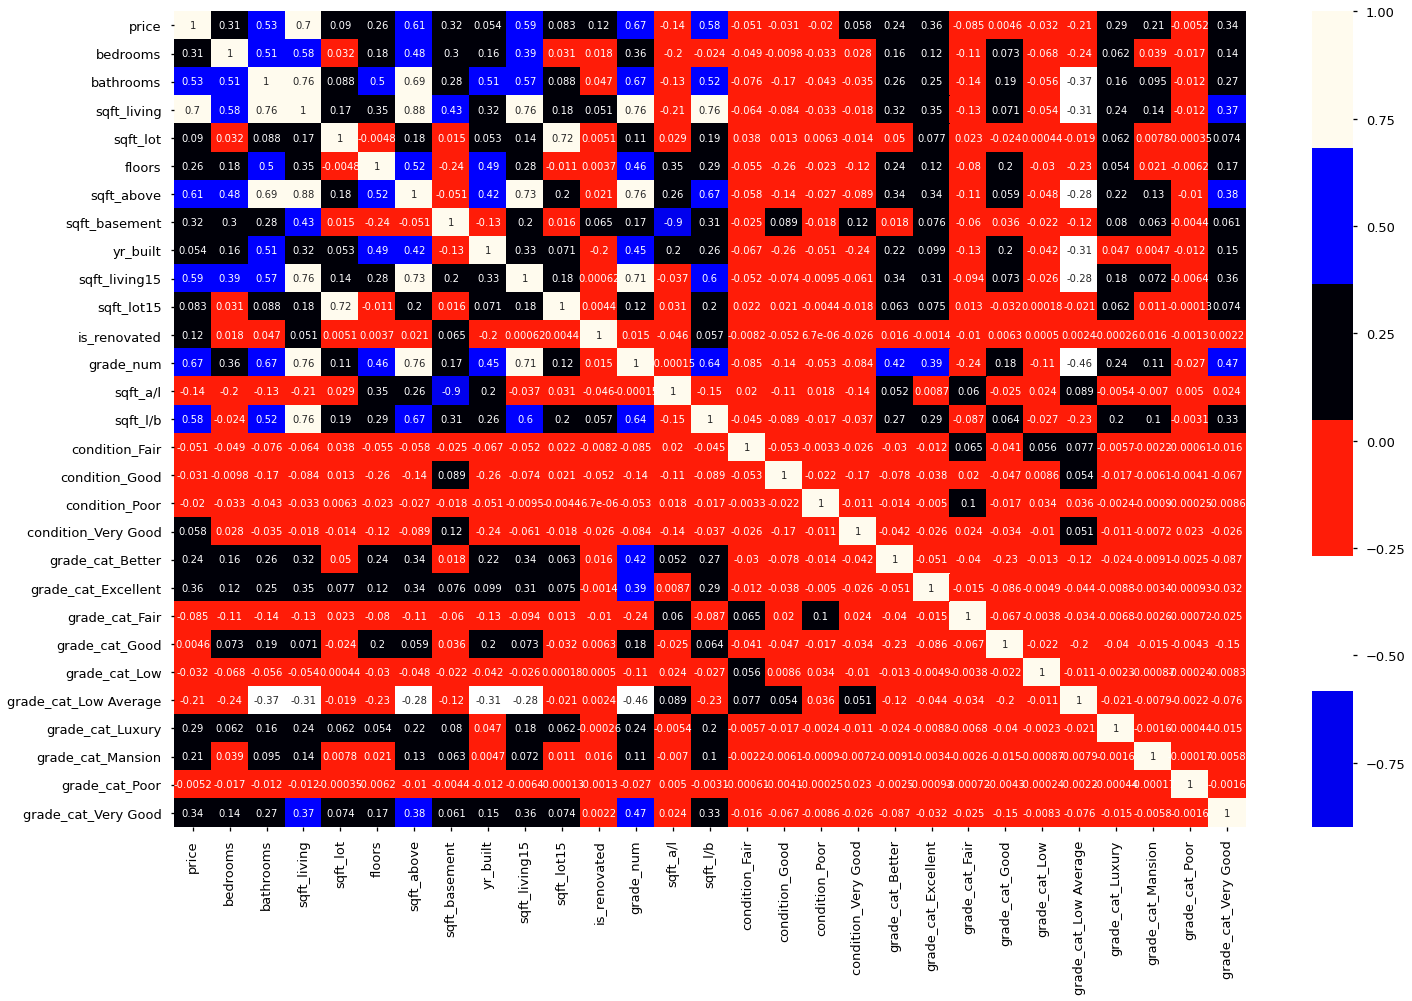

In [446]:
# Early correlation matrix to understand relationships with what we currently have.

plt.figure(figsize = (24,15))
corrM = df_clean.corr()

sns.heatmap(corrM, annot=True, cmap=pal)
plt.show()

## Initial EDA

I am going to first focus on 3 variables that have traditionally been included when determining the price of a house, the number of bedrooms, the number of bathrooms, and the square footage of the living area.  I am going to dig into these individually, and then look at the broader data before running any regressions.

In [447]:
# Look at initial distributions of columns

df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,285.716581,1970.999676,1986.620318,...,0.121082,0.018475,0.011205,0.280826,0.001250,0.094365,0.004121,0.000602,0.000046,0.052507
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,439.819830,29.375234,685.230472,...,0.326230,0.134664,0.105263,0.449413,0.035337,0.292343,0.064064,0.024528,0.006805,0.223053
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,0.000000,1900.000000,399.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,1490.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,1840.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,550.000000,1997.000000,2360.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,6210.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Average price is 540k, and median price is 450k, suggesting that there are some outliers driving the average higher than the median number.  This is also realized with bedrooms, sqft_living.  Which makes sense if we have some higher cost houses.  Conventional thought, I would expect those to be similarly distributed as the price because that is what I think typically drives the price of a house.

<AxesSubplot:xlabel='price', ylabel='Count'>

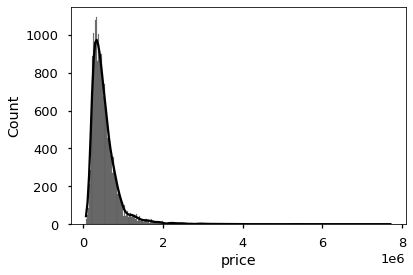

In [448]:
# Quick look at price, our dependent variable

sns.histplot(data=df_clean, x='price', kde=True, color='black')

Distribution seems to be right skewed.  Meaning that our mean is above our Median and being inflated by outliers.

<AxesSubplot:xlabel='price', ylabel='Count'>

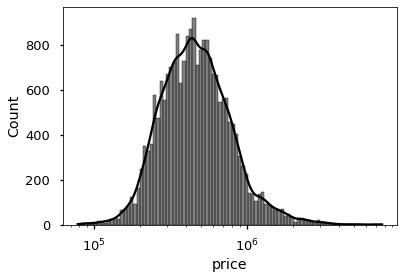

In [449]:
# Quick look at price, our dependent variable transformed as a log value

sns.histplot(data=df_clean, x='price', kde=True, log_scale=True, color='black')

This looks much better.  I am going to keep my original values for the first values, but then will most likely change to a log scale in order to distribute the data normally.

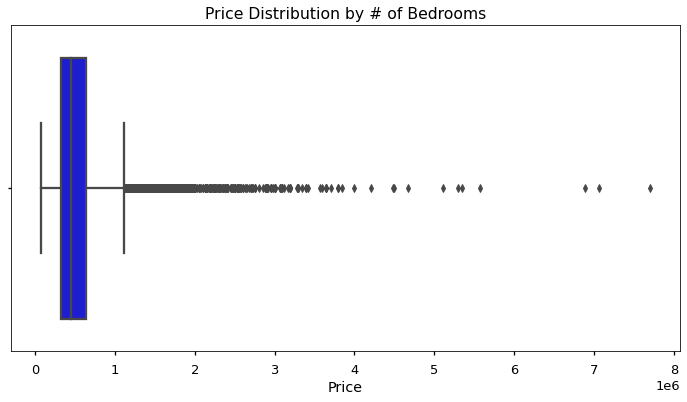

In [450]:
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Price Distribution by # of Bedrooms')


bp = sns.boxplot(data=df_clean, 
            x='price',  
            palette=pal)

bp.set_xlabel('Price');

Going to check to see how many records we would drop if we remove outliers outside of IQR.


In [451]:
# developing variables for IQR removal, and record count.
price_Q1 = df_clean['price'].quantile(0.25)
price_Q3 = df_clean['price'].quantile(0.75)

IQR = price_Q3 - price_Q1

lower_bnd = price_Q1 - 1.5 * IQR
upper_bnd = price_Q3 + 1.5 * IQR


In [452]:
# creating variable for lower bound
outliers_low = df_clean['price'] > lower_bnd

In [453]:
# creating variable for lower bound
outliers_up = df_clean['price'] < upper_bnd

In [454]:
print("% of Records Retained After Oulier Removal:", 
      "{:.1%}".format(len(df_clean['price'][~outliers_low | outliers_up])/ len(df_clean))
     )

% of Records Retained After Oulier Removal: 94.6%


<AxesSubplot:xlabel='price', ylabel='Count'>

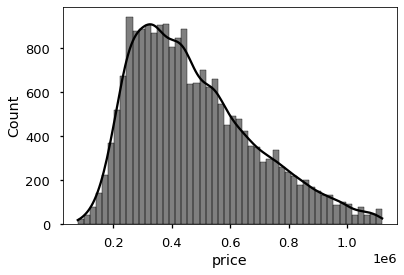

In [455]:
# taking a look at the new distribution less outliers
price_check = df_clean['price'][~outliers_low | outliers_up]

sns.histplot(data=price_check, kde=True, color='black')

''

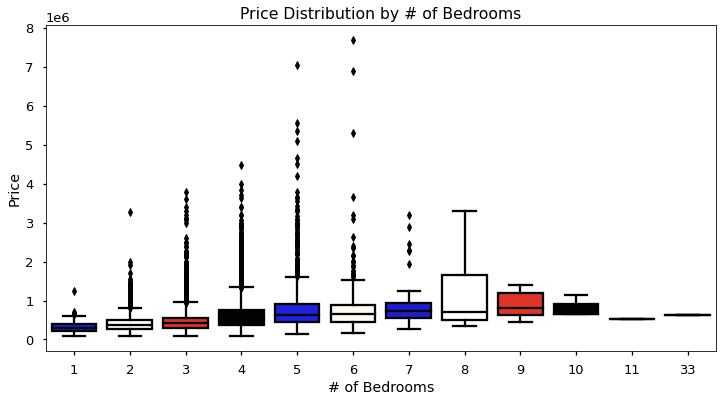

In [456]:
# boxplots for # of bedrooms and price

fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Price Distribution by # of Bedrooms')


bp = sns.boxplot(data=df_clean, 
            y='price', 
            x='bedrooms', 
            palette=pal)

bp.set_ylabel('Price')
bp.set_xlabel('# of Bedrooms')
;

Removing outliers seems like it would be a good option.  Also probably easier than trying to interpret log transformed coefficients.  Will most likely try outlier removal first, then log transform.

''

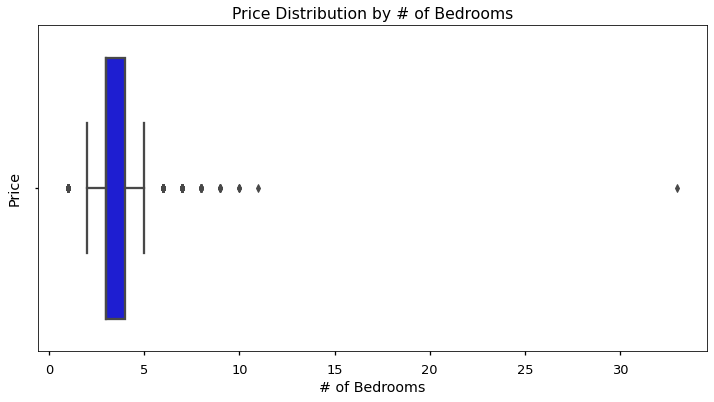

In [457]:
# taking a look at bedrooms only
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Price Distribution by # of Bedrooms')


bp = sns.boxplot(data=df_clean, 
            x='bedrooms', 
            palette=pal)

bp.set_ylabel('Price')
bp.set_xlabel('# of Bedrooms')
;

There doesn't seem to be a large difference between the median home price, as the number of bedrooms increase.  In fact, most of the outliers for price, are situated within the non-outlier values of bedrooms.  With that being said, there does seem to be a subtle increase in price, as the number of bedrooms increase.  The one record with the 33 bedrooms is a bit bothersome, however it doesn't look like the house really got the benefit of having that many bedrooms because the price was just above the average, and the sqft_living is below the median.  To me this looks like an error in the data in that it should be represented as 3 bedrooms, instead of 33 bedrooms.  The median, and the 25th percentiles are the same for bedrooms, with 3 bedrooms.

In [458]:
# isolating the bedroom row with 33 bedrooms for further inspection

df_clean.loc[df_clean['bedrooms'] == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
15856,640000.0,33,1.75,1620,6000,1.0,1040,580.0,1947,1330,...,0,0,0,0,0,0,0,0,0,0


In [459]:
# replacing 33 bedroom value with 3 bedrooms

df_clean['bedrooms'] = df['bedrooms'].replace([33],3)

''

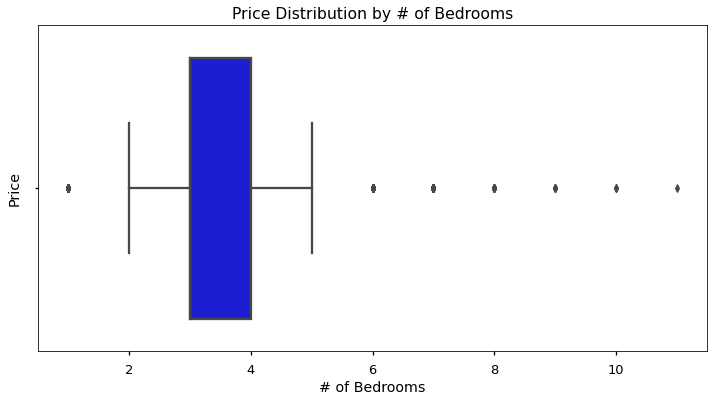

In [460]:
# quick view to make sure our operation worked.

fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Price Distribution by # of Bedrooms')


bp = sns.boxplot(data=df_clean, 
            x='bedrooms', 
            palette=pal)

bp.set_ylabel('Price')
bp.set_xlabel('# of Bedrooms')
;

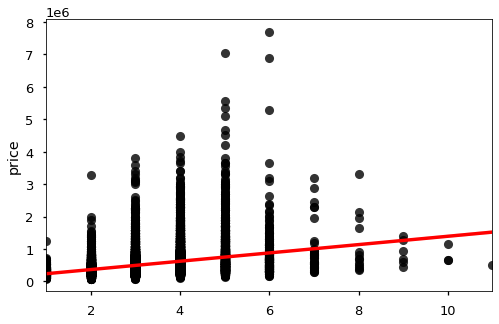

In [461]:
# scatter to look at the data between our bedroom variable and price.

plt.figure(figsize = (8,5))

rp = sns.regplot(x='bedrooms',
            y='price', 
            data=df_clean,
            scatter_kws={"color": "black"}, 
            line_kws={"color": "red"})

rp.set_ylabel('price')
rp.set_xlabel('')
rp.set_title('');

There seems to be a moderate correlation between the number of bedrooms and our price variable.  The data looks much more consistent without the 33 bedrooms.  I think the 33 bedrooms may have been inflating our expectations of the influence that bedrooms actually has on price.  There are a few outliers that remain, we will run a regression first and then determine if removing additional will be valuable.  Moving on to bathrooms next.

''

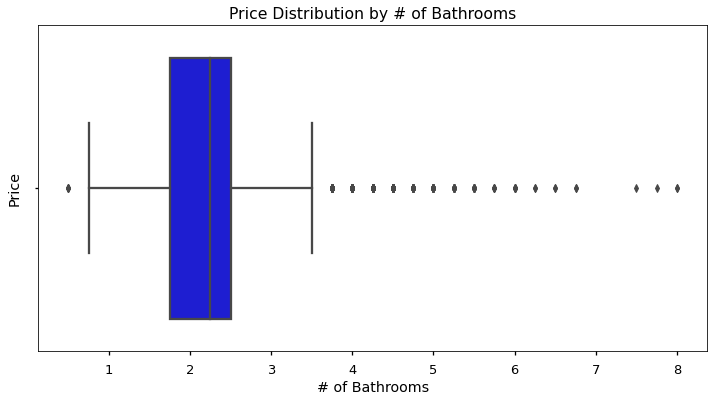

In [462]:
# quick view to make sure our operation worked.

fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Price Distribution by # of Bathrooms')


bp = sns.boxplot(data=df_clean, 
            x='bathrooms', 
            palette=pal)

bp.set_ylabel('Price')
bp.set_xlabel('# of Bathrooms')
;

A few outliers based on the boxplot, while most bathrooms are between .75 and 3.5.

''

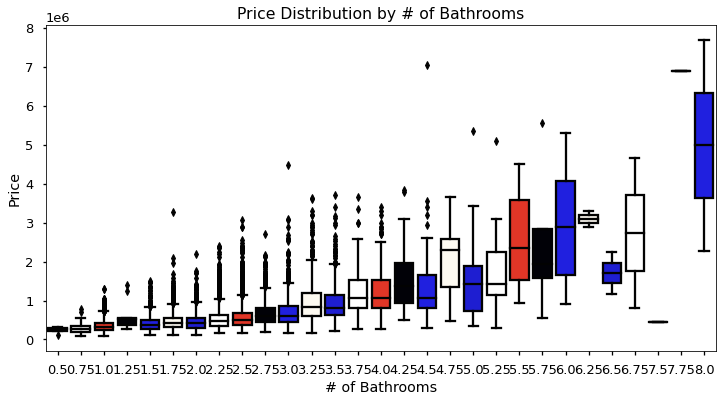

In [463]:
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Price Distribution by # of Bathrooms')


bp = sns.boxplot(data=df_clean, 
            y='price', 
            x='bathrooms', 
            palette=pal)

bp.set_ylabel('Price')
bp.set_xlabel('# of Bathrooms')
;

Not crazy about all these .25, and .75 baths.  Especially since the lower end of values have a lot of overlap in price distribution.  Going to create another column that rounds up to the nearest half bath.  

In [464]:
# create a new column for rounded bathrooms.

df_clean['baths_rnd'] = (np.ceil(df_clean['bathrooms'] * 2) / 2)

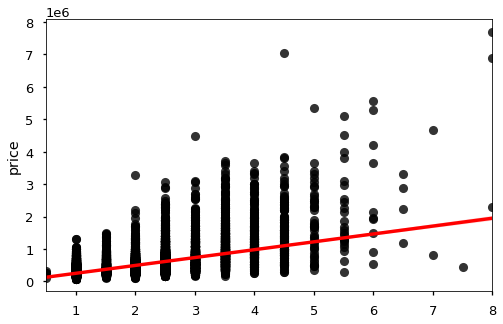

In [465]:
# scatter plot for my rounded bathrooms and the 

plt.figure(figsize = (8,5))

rp = sns.regplot(x='baths_rnd',
            y='price', 
            data=df_clean,
            scatter_kws={"color": "black"}, 
            line_kws={"color": "red"})

rp.set_ylabel('price')
rp.set_xlabel('')
rp.set_title('');

Once again a slight correlation with price.  At a glance it looks like bathrooms have a stronger impact on price vs # the number of bedrooms listed on a house.  If this does turn out to be the case, then suggesting bathroom upgrades and potentially rounding up existing bathrooms would be easy enhancements to increase the value of a home for our customers.

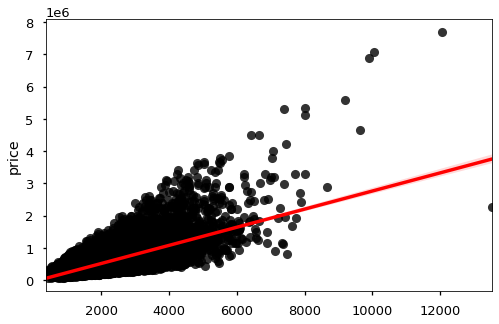

In [466]:
# lets take a quick look at price vs living area square footage.

plt.figure(figsize = (8,5))

rp = sns.regplot(x='sqft_living',
            y='price', 
            data=df_clean,
            scatter_kws={"color": "black"}, 
            line_kws={"color": "red"})

rp.set_ylabel('price')
rp.set_xlabel('')
rp.set_title('');

So at a glance, it seems as if living area square footage will have the highest impact on the sale price of a home.  We will see if this holds true in our analysis/ regression.

## Regression Modeling

## Model 1

In [467]:
# creating our first regression on basic parameters as a baseline.

# create target 

target1 = df_clean['price']

# create predictors
predictors1 = df_clean.drop(['price'], axis=1)

# create model intercept
predictors_int1 = sm.add_constant(predictors1)

# fit model to data
model1 = sm.OLS(df_clean['price'],predictors_int1).fit()

In [468]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     1481.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:54:53   Log-Likelihood:            -2.9581e+05
No. Observations:               21597   AIC:                         5.917e+05
Df Residuals:                   21568   BIC:                         5.919e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.633e+06   1.09e+05     33.248      0.000    3.42e+06    3.85e+06
bedrooms              -6.537e+04   4824.658    -13.550      0.000   -7.48e+04   -5.59e+04
bathrooms             -2.552e+04   1.38e+04     -1.855      0.064   -5.25e+04    1449.994
sqft_living             292.8645     21.710     13.490      0.000     250.311     335.418
sqft_lot                  0.0145      0.051      0.283      0.777      -0.086       0.115
floors                 4.903e+04   3866.277     12.681      0.000    4.14e+04    5.66e+04
sqft_above             -140.9384     21.570     -6.534      0.000    -183.217     -98.660
sqft_basement            48.9285     19.138      2.557      0.011      11.416      86.441
yr_built              -3420.3193     71.347    -47.939      0.000   -3560.164   -3280.474
sqft_living15            44.8949      3.598     12.478      0.000      37.843      51.947
sqft_lot15               -0.5276      0.078     -6.757      0.000      -0.681      -0.375
is_renovated           6.822e+04   8491.465      8.034      0.000    5.16e+04    8.49e+04
grade_num              4.192e+05   8199.664     51.125      0.000    4.03e+05    4.35e+05
sqft_a/l               3.475e+05   2.58e+04     13.470      0.000    2.97e+05    3.98e+05
sqft_l/b               -171.3378     24.175     -7.087      0.000    -218.722    -123.954
condition_Fair        -3.098e+04   1.68e+04     -1.845      0.065   -6.39e+04    1935.242
condition_Good         1.924e+04   3687.608      5.217      0.000     1.2e+04    2.65e+04
condition_Poor        -2.969e+04   4.03e+04     -0.736      0.462   -1.09e+05    4.94e+04
condition_Very Good    6.002e+04   5928.825     10.124      0.000    4.84e+04    7.16e+04
grade_cat_Better      -6.107e+05   1.64e+04    -37.163      0.000   -6.43e+05   -5.79e+05
grade_cat_Excellent   -9.895e+05   3.39e+04    -29.192      0.000   -1.06e+06   -9.23e+05
grade_cat_Fair         6.975e+05   2.07e+04     33.710      0.000    6.57e+05    7.38e+05
grade_cat_Good        -3.344e+05   8552.379    -39.106      0.000   -3.51e+05   -3.18e+05
grade_cat_Low          1.086e+06   4.59e+04     23.680      0.000    9.96e+05    1.18e+06
grade_cat_Low Average  3.352e+05   9230.912     36.312      0.000    3.17e+05    3.53e+05
grade_cat_Luxury      -9.086e+05   4.52e+04    -20.114      0.000   -9.97e+05    -8.2e+05
grade_cat_Mansion     -2.743e+05   6.84e+04     -4.013      0.000   -4.08e+05    -1.4e+05
grade_cat_Poor         1.446e+06   1.97e+05      7.356      0.000    1.06e+06    1.83e+06
grade_cat_Very Good   -8.447e+05   2.49e+04    -33.978      0.000   -8.93e+05   -7.96e+05
baths_rnd              7.711e+04    1.3e+04      5.927      0.000    5.16e+04    1.03e+05
==============================================================================
Omnibus:                    13997.

Good first test.  Higher r2 than what I was anticipating.  I think we might have some co-linear features impacting our score and helping our model along.  I am concerned that our bathrooms feature has such a high p-value.  Another high p-value is sqft_lot; we can remove this feature as it will not really impact our recommendations to the customers.  Being able to add square footage to your lot isn't always the easiest.  With that being said, I am also going to remove both of the _15 metrics as those are also variables that will not help our customers.

In [469]:
# removing sqft_living15 and sqft_lot15

df_clean = df_clean.drop(['sqft_lot15', 'sqft_living15'], axis=1)

## Model 2

In [470]:
# create target
target2 = df_clean['price']

#create predictors
predictors2 = df_clean.drop(['price'], axis=1)

# create model intercept
predictors_int2 = sm.add_constant(predictors2)

# fit model to data
model2 = sm.OLS(df_clean['price'],predictors_int2).fit()

In [471]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     1574.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:54:53   Log-Likelihood:            -2.9590e+05
No. Observations:               21597   AIC:                         5.919e+05
Df Residuals:                   21570   BIC:                         5.921e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.631e+06    1.1e+05     33.126      0.000    3.42e+06    3.85e+06
bedrooms              -6.469e+04   4845.438    -13.350      0.000   -7.42e+04   -5.52e+04
bathrooms             -2.745e+04   1.38e+04     -1.987      0.047   -5.45e+04    -377.263
sqft_living             293.4748     21.801     13.461      0.000     250.742     336.207
sqft_lot                 -0.2299      0.037     -6.269      0.000      -0.302      -0.158
floors                 4.294e+04   3830.499     11.209      0.000    3.54e+04    5.04e+04
sqft_above             -122.6786     21.617     -5.675      0.000    -165.050     -80.307
sqft_basement            54.4519     19.218      2.833      0.005      16.784      92.120
yr_built              -3402.0532     71.491    -47.587      0.000   -3542.181   -3261.926
is_renovated            6.47e+04   8524.710      7.590      0.000     4.8e+04    8.14e+04
grade_num              4.231e+05   8226.776     51.428      0.000    4.07e+05    4.39e+05
sqft_a/l               3.353e+05   2.59e+04     12.947      0.000    2.85e+05    3.86e+05
sqft_l/b               -169.5202     24.271     -6.984      0.000    -217.093    -121.947
condition_Fair         -3.06e+04   1.69e+04     -1.814      0.070   -6.37e+04    2460.254
condition_Good          1.92e+04   3702.570      5.186      0.000    1.19e+04    2.65e+04
condition_Poor        -1.207e+04   4.05e+04     -0.298      0.766   -9.14e+04    6.73e+04
condition_Very Good    5.839e+04   5953.535      9.808      0.000    4.67e+04    7.01e+04
grade_cat_Better      -5.966e+05   1.64e+04    -36.312      0.000   -6.29e+05   -5.64e+05
grade_cat_Excellent   -9.688e+05    3.4e+04    -28.533      0.000   -1.04e+06   -9.02e+05
grade_cat_Fair         7.025e+05   2.08e+04     33.818      0.000    6.62e+05    7.43e+05
grade_cat_Good        -3.277e+05   8560.161    -38.284      0.000   -3.44e+05   -3.11e+05
grade_cat_Low          1.105e+06   4.61e+04     23.992      0.000    1.01e+06     1.2e+06
grade_cat_Low Average  3.336e+05   9264.321     36.011      0.000    3.15e+05    3.52e+05
grade_cat_Luxury      -8.921e+05   4.53e+04    -19.693      0.000   -9.81e+05   -8.03e+05
grade_cat_Mansion     -2.889e+05   6.86e+04     -4.209      0.000   -4.23e+05   -1.54e+05
grade_cat_Poor         1.467e+06   1.97e+05      7.431      0.000    1.08e+06    1.85e+06
grade_cat_Very Good   -8.267e+05   2.49e+04    -33.224      0.000   -8.76e+05   -7.78e+05
baths_rnd              7.837e+04   1.31e+04      5.999      0.000    5.28e+04    1.04e+05
==============================================================================
Omnibus:                    13726.853   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           559123.091
Skew:                           2.478   Prob(JB):       

A little bit worse, but pretty consistent - .658 vs .655 r2. I am going to remove the outliers from my dependent variable price, to see if we can improve upon the r2 value.

In [472]:
# Removing outliers, and checking row count compared to what we had above =20439

df_clean_out = df_clean[df_clean['price'].between(lower_bnd, upper_bnd)]

len(df_clean_out)

20439

## Model 3

In [473]:
# model 3 includes same variables excluding price outliers
# create target
target3 = df_clean_out['price']

# create predictors
predictors3 = df_clean_out.drop(['price'], axis=1)

# create model intercept
predictors_int3 = sm.add_constant(predictors3)

# fit model to data
model3 = sm.OLS(df_clean_out['price'],predictors_int3).fit()

In [474]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1073.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:54:53   Log-Likelihood:            -2.7069e+05
No. Observations:               20439   AIC:                         5.414e+05
Df Residuals:                   20413   BIC:                         5.416e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   3.19e+06   6.94e+04     45.939      0.000    3.05e+06    3.33e+06
bedrooms              -1.489e+04   3378.425     -4.406      0.000   -2.15e+04   -8264.311
bathrooms             -1.009e+04   9085.717     -1.111      0.267   -2.79e+04    7717.255
sqft_living              44.3705     15.697      2.827      0.005      13.602      75.139
sqft_lot                  0.0433      0.025      1.756      0.079      -0.005       0.092
floors                 4.449e+04   2522.199     17.641      0.000    3.96e+04    4.94e+04
sqft_above               39.2956     15.543      2.528      0.011       8.830      69.762
sqft_basement            20.7596     13.401      1.549      0.121      -5.508      47.027
yr_built              -2664.7916     47.843    -55.699      0.000   -2758.567   -2571.016
is_renovated            1.01e+04   5838.598      1.730      0.084   -1342.102    2.15e+04
grade_num              3.323e+05   6926.660     47.976      0.000    3.19e+05    3.46e+05
sqft_a/l              -1.051e+05    1.9e+04     -5.537      0.000   -1.42e+05   -6.79e+04
sqft_l/b                  9.5112     17.154      0.554      0.579     -24.113      43.135
condition_Fair        -4.853e+04   1.07e+04     -4.517      0.000   -6.96e+04   -2.75e+04
condition_Good         1.001e+04   2399.171      4.173      0.000    5309.010    1.47e+04
condition_Poor        -4.309e+04   2.61e+04     -1.652      0.099   -9.42e+04    8033.406
condition_Very Good    4.117e+04   3913.090     10.522      0.000    3.35e+04    4.88e+04
grade_cat_Better      -4.299e+05   1.39e+04    -30.999      0.000   -4.57e+05   -4.03e+05
grade_cat_Excellent   -9.495e+05   2.97e+04    -31.979      0.000   -1.01e+06   -8.91e+05
grade_cat_Fair         5.227e+05   1.58e+04     33.022      0.000    4.92e+05    5.54e+05
grade_cat_Good        -2.264e+05   7067.812    -32.031      0.000    -2.4e+05   -2.13e+05
grade_cat_Low           8.49e+05   3.18e+04     26.716      0.000    7.87e+05    9.11e+05
grade_cat_Low Average  2.389e+05   7317.100     32.645      0.000    2.25e+05    2.53e+05
grade_cat_Luxury      -1.326e+06   5.99e+04    -22.129      0.000   -1.44e+06   -1.21e+06
grade_cat_Mansion      3.417e-10    3.9e-11      8.752      0.000    2.65e-10    4.18e-10
grade_cat_Poor         1.148e+06   1.22e+05      9.377      0.000    9.08e+05    1.39e+06
grade_cat_Very Good   -6.857e+05   2.11e+04    -32.476      0.000   -7.27e+05   -6.44e+05
baths_rnd              3.589e+04   8566.502      4.189      0.000    1.91e+04    5.27e+04
==============================================================================
Omnibus:                      902.851   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1300.961
Skew:                           0.422   Prob(JB):       

In [475]:
# removing columns with > .05 p values and going to rerun model 3
df_clean_out = df_clean_out.drop(['sqft_l/b', 
                                  'sqft_basement',
                                  'sqft_lot',
                                  'is_renovated',
                                  'condition_Poor', 
                                  'bathrooms'], axis=1)

df_clean_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20439 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  20439 non-null  float64
 1   bedrooms               20439 non-null  int64  
 2   sqft_living            20439 non-null  int64  
 3   floors                 20439 non-null  float64
 4   sqft_above             20439 non-null  int64  
 5   yr_built               20439 non-null  int64  
 6   grade_num              20439 non-null  int64  
 7   sqft_a/l               20439 non-null  float64
 8   condition_Fair         20439 non-null  uint8  
 9   condition_Good         20439 non-null  uint8  
 10  condition_Very Good    20439 non-null  uint8  
 11  grade_cat_Better       20439 non-null  uint8  
 12  grade_cat_Excellent    20439 non-null  uint8  
 13  grade_cat_Fair         20439 non-null  uint8  
 14  grade_cat_Good         20439 non-null  uint8  
 15  gr

## Model 3b

In [476]:
# model 3b - removed outliers, combined with features with p values > .05

# create target
target3b = df_clean_out['price']

# create predictors
predictors3b = df_clean_out.drop(['price'], axis=1)

# create model intercept
predictors_int3b = sm.add_constant(predictors3b)

# fit model to data
model3b = sm.OLS(df_clean_out['price'],predictors_int3b).fit()

In [477]:
model3b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1410.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:55:10   Log-Likelihood:            -2.7070e+05
No. Observations:               20439   AIC:                         5.414e+05
Df Residuals:                   20419   BIC:                         5.416e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.228e+06   6.56e+04     49.200      0.000     3.1e+06    3.36e+06
bedrooms              -1.698e+04   1424.651    -11.921      0.000   -1.98e+04   -1.42e+04
sqft_living              66.8322      7.570      8.828      0.000      51.994      81.671
floors                 4.379e+04   2476.365     17.681      0.000    3.89e+04    4.86e+04
sqft_above               20.3301      8.333      2.440      0.015       3.998      36.663
yr_built              -2689.8930     45.453    -59.180      0.000   -2778.984   -2600.802
grade_num              3.352e+05   6705.976     49.978      0.000    3.22e+05    3.48e+05
sqft_a/l              -1.075e+05   1.86e+04     -5.782      0.000   -1.44e+05   -7.11e+04
condition_Fair        -4.778e+04   1.07e+04     -4.454      0.000   -6.88e+04   -2.68e+04
condition_Good         9979.7651   2369.015      4.213      0.000    5336.306    1.46e+04
condition_Very Good    4.055e+04   3881.269     10.447      0.000    3.29e+04    4.82e+04
grade_cat_Better      -4.358e+05   1.34e+04    -32.521      0.000   -4.62e+05    -4.1e+05
grade_cat_Excellent   -9.624e+05   2.86e+04    -33.657      0.000   -1.02e+06   -9.06e+05
grade_cat_Fair         5.265e+05   1.55e+04     33.941      0.000    4.96e+05    5.57e+05
grade_cat_Good        -2.291e+05   6872.624    -33.339      0.000   -2.43e+05   -2.16e+05
grade_cat_Low           8.56e+05   3.14e+04     27.261      0.000    7.94e+05    9.18e+05
grade_cat_Low Average  2.411e+05   7168.536     33.633      0.000    2.27e+05    2.55e+05
grade_cat_Luxury      -1.344e+06    5.9e+04    -22.773      0.000   -1.46e+06   -1.23e+06
grade_cat_Mansion      1.457e-10   1.18e-11     12.301      0.000    1.23e-10    1.69e-10
grade_cat_Poor         1.161e+06   1.22e+05      9.492      0.000    9.21e+05     1.4e+06
grade_cat_Very Good   -6.949e+05   2.03e+04    -34.147      0.000   -7.35e+05   -6.55e+05
baths_rnd              2.712e+04   2216.692     12.234      0.000    2.28e+04    3.15e+04
==============================================================================
Omnibus:                      906.836   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1308.285
Skew:                           0.423   Prob(JB):                    8.12e-285
Kurtosis:                       3.906   Cond. No.                     1.64e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.69e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

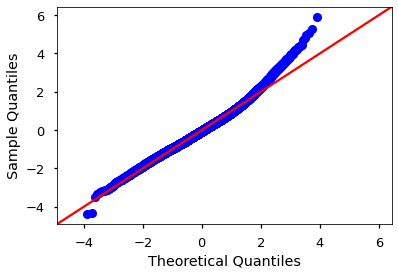

In [478]:
res = model3b.resid # residuals
fig = sm.qqplot(res, fit=True, line='45')
plt.show()

<AxesSubplot:ylabel='Count'>

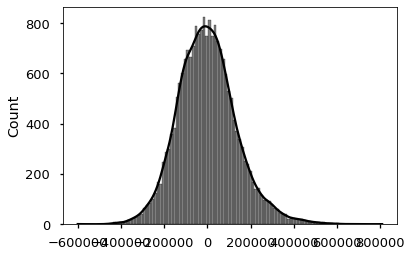

In [479]:
sns.histplot(data=res, kde=True, color='black')

In [480]:
lr.fit(predictors3b, target3b)

LinearRegression()

In [481]:
y_hat = lr.predict(predictors3b)
y_hat

array([330546.13150636, 555530.12798787, 276914.74556453, ...,
       232113.93938188, 425837.18355093, 234803.83233241])

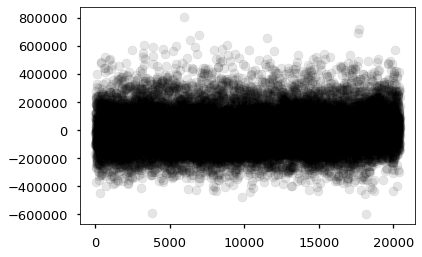

In [482]:
resid = (target3b - y_hat)
plt.scatter(x=range(y_hat.shape[0]), y=resid, alpha=0.1, color='black')

In [483]:
metrics.mean_absolute_error(target3b, y_hat)

106029.92147767638

In [484]:
metrics.mean_squared_error(target3b, y_hat, squared=False)

136642.39728154428

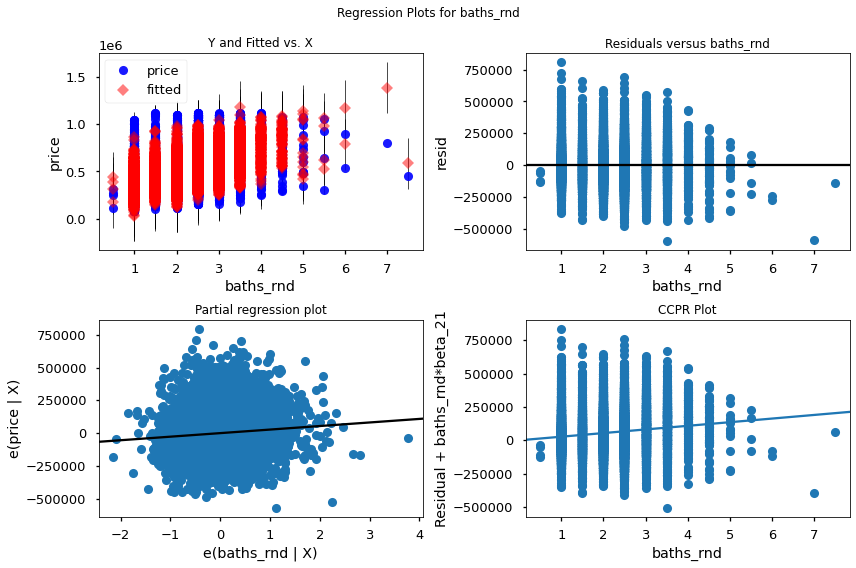

In [485]:
sm.graphics.plot_regress_exog(model3b, 'baths_rnd', fig=plt.figure(figsize=(12,8)));

In [ ]:
sm.graphics.plot_regress_exog(model3b, 'baths_rnd', fig=plt.figure(figsize=(12,8)));

## Model3c

In [418]:
# log transforming the price column

df_clean_out['price_log'] = np.log(df_clean_out['price'])
df_clean_out = df_clean_out.drop(['price', 'sqft_living'], axis=1)
df_clean_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20439 entries, 0 to 21596
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               20439 non-null  int64  
 1   bathrooms              20439 non-null  float64
 2   sqft_lot               20439 non-null  int64  
 3   floors                 20439 non-null  float64
 4   sqft_above             20439 non-null  int64  
 5   sqft_basement          20439 non-null  float64
 6   yr_built               20439 non-null  int64  
 7   is_renovated           20439 non-null  int64  
 8   grade_num              20439 non-null  int64  
 9   sqft_a/l               20439 non-null  float64
 10  sqft_l/b               20439 non-null  float64
 11  condition_Fair         20439 non-null  uint8  
 12  condition_Good         20439 non-null  uint8  
 13  condition_Poor         20439 non-null  uint8  
 14  condition_Very Good    20439 non-null  uint8  
 15  gr

<ipython-input-418-7739fead099e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_out['price_log'] = np.log(df_clean_out['price'])


In [419]:
# model 3b - removed outliers, combined with features with p values > .05

# create target
target3c = df_clean_out['price_log']

# create predictors
predictors3c = df_clean_out.drop(['price_log'], axis=1)

# create model intercept
predictors_int3c = sm.add_constant(predictors3c)

# fit model to data
model3c = sm.OLS(df_clean_out['price_log'],predictors_int3c).fit()

In [420]:
model3c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     1028.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:53:02   Log-Likelihood:                -4367.1
No. Observations:               20439   AIC:                             8784.
Df Residuals:                   20414   BIC:                             8982.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.5791      0.152     95.836      0.000      14.281      14.877
bedrooms                 -0.0198      0.007     -2.771      0.006      -0.034      -0.006
bathrooms                -0.0174      0.020     -0.873      0.383      -0.056       0.022
sqft_lot                2.03e-07    5.4e-08      3.759      0.000    9.71e-08    3.09e-07
floors                    0.1105      0.006     20.008      0.000       0.100       0.121
sqft_above                0.0002   1.26e-05     12.573      0.000       0.000       0.000
sqft_basement          1.236e-05   1.61e-05      0.768      0.442   -1.92e-05    4.39e-05
yr_built                 -0.0056      0.000    -53.730      0.000      -0.006      -0.005
is_renovated             -0.0083      0.013     -0.651      0.515      -0.033       0.017
grade_num                 1.3238      0.015     87.216      0.000       1.294       1.354
sqft_a/l                 -0.4972      0.038    -12.918      0.000      -0.573      -0.422
sqft_l/b               9.758e-05   3.63e-05      2.688      0.007    2.64e-05       0.000
condition_Fair           -0.1794      0.024     -7.615      0.000      -0.226      -0.133
condition_Good            0.0150      0.005      2.844      0.004       0.005       0.025
condition_Poor           -0.1629      0.057     -2.847      0.004      -0.275      -0.051
condition_Very Good       0.0752      0.009      8.768      0.000       0.058       0.092
grade_cat_Better         -2.1964      0.030    -72.240      0.000      -2.256      -2.137
grade_cat_Excellent      -4.7235      0.065    -72.552      0.000      -4.851      -4.596
grade_cat_Fair            2.1814      0.035     62.937      0.000       2.113       2.249
grade_cat_Good           -1.0869      0.015    -70.133      0.000      -1.117      -1.057
grade_cat_Low             3.4195      0.070     49.123      0.000       3.283       3.556
grade_cat_Low Average     1.0578      0.016     66.028      0.000       1.026       1.089
grade_cat_Luxury         -6.1704      0.131    -46.943      0.000      -6.428      -5.913
grade_cat_Mansion      1.967e-16   7.97e-18     24.663      0.000    1.81e-16    2.12e-16
grade_cat_Poor            4.8808      0.269     18.172      0.000       4.354       5.407
grade_cat_Very Good      -3.4339      0.046    -74.169      0.000      -3.525      -3.343
baths_rnd                 0.0768      0.019      4.091      0.000       0.040       0.114
==============================================================================
Omnibus:                      142.731   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.820
Skew:                          -0.175   Prob(JB):                     3.97e-34
Kurtosis:                       3.242   Cond. No.                  

# Archive

In [ ]:
og_cats = df_clean.iloc[:, 0:12]
og_cats.hist(figsize  = [12, 12], bins='auto', color='black')
plt.tight_layout(pad=0.5, w_pad=0.75, h_pad=1.0);

A decent amount of skew in our variables.  Even though it will make it a little more difficult to interpret our coefficients, if we are able to achieve our a better normality assumption then I think we can figure it out!  First we will need to identify our non-zero columns as they will not take well to the log conversation.

In [ ]:
no_zero_og_cats = ['price', 
                   'bedrooms',
                   'bathrooms',
                   'sqft_living',
                   'sqft_above',
                   'grade_num']

df_clean_nzoc = df_clean[no_zero_og_cats]
df_clean_nzoc.head()

In [ ]:
df_log = [f'{column}_log' for column in df_clean_nzoc.columns]

log = np.log(df_clean_nzoc)
log.columns = df_log
log.hist(figsize=(12, 12), bins='auto', color='black')
plt.tight_layout(pad=0.5, w_pad=0.75, h_pad=1.0);

These distributions look much better.  Going to bring them back into my main dataset for another regression model.  Then depending on the values, we may test our regression assumptions.

In [ ]:
df_final = pd.concat([log, df_clean], axis = 1)
df_final = df_final.drop(no_zero_og_cats, axis = 1)

In [ ]:
df_final.head()

In [ ]:

predictors = df_final.drop(['price_log'], axis=1)

# create model intercept
predictors_int = sm.add_constant(predictors)

# fit model to data
model4 = sm.OLS(df_final['price_log'],predictors_int).fit()

In [ ]:
model4.summary()

Well, not what I was completely expecting.  Looks like my previous model had better results than performing log transformations on my dependent variable and a few of my independent variables.  I will be going to go back to my second model and test my assumptions to start pressure testing our assumptions, and our coefficient interpretation.  From there if things still need to be adjusted then I wlll go back and look at outliers.

### Correlation Matrix & Colinearity

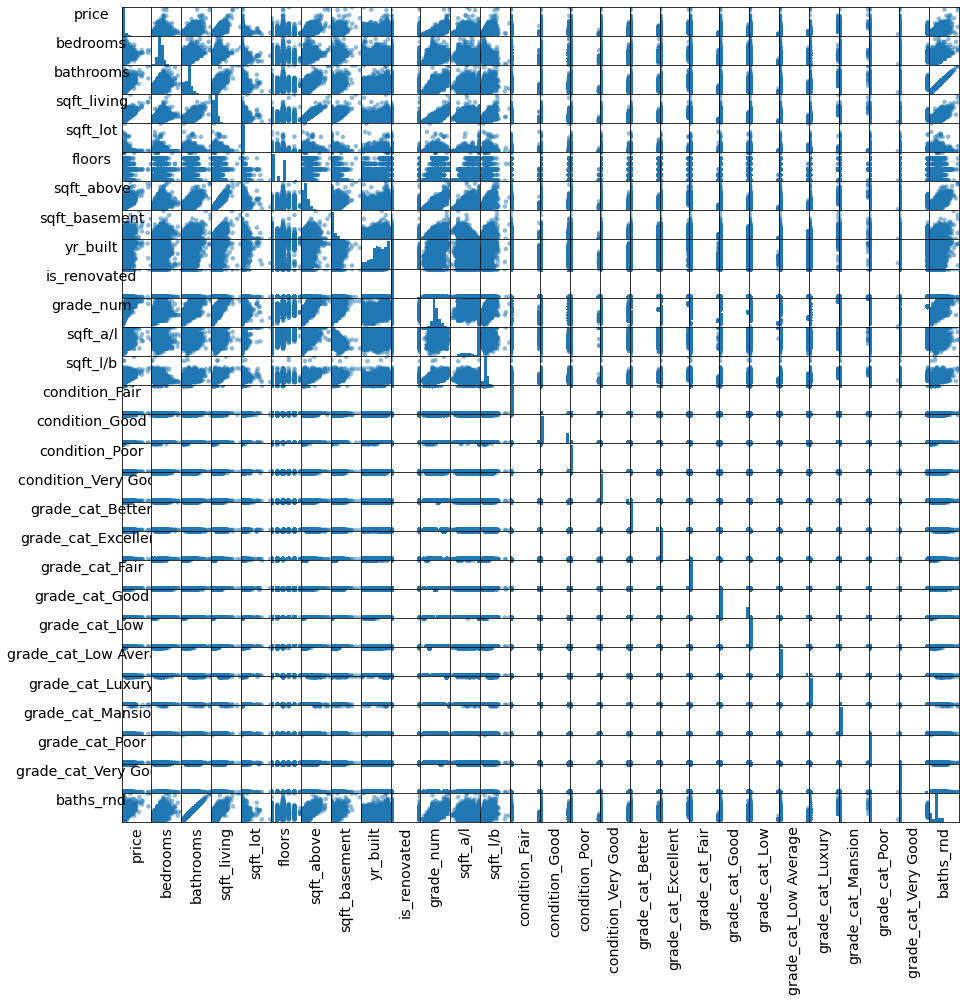

In [486]:
sm = pd.plotting.scatter_matrix(df_clean_out, figsize = [15,15]);

# Rotates the text
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

In [487]:
df_clean_out.corr()

,price,bedrooms,sqft_living,floors,sqft_above,yr_built,grade_num,sqft_a/l,condition_Fair,condition_Good,...,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good,baths_rnd
price,1.000000,0.300832,0.621362,0.273360,0.529931,0.061264,0.630980,-0.139485,-0.073167,-0.033339,...,0.179408,-0.120206,0.150452,-0.046332,-0.280575,0.037664,NaN,-0.007228,0.314374,0.454647
bedrooms,0.300832,1.000000,0.601457,0.160827,0.478118,0.166782,0.329053,-0.194203,-0.049246,-0.003771,...,0.066369,-0.116506,0.104062,-0.071447,-0.242211,0.015402,NaN,-0.018430,0.105946,0.504063
sqft_living,0.621362,0.601457,1.000000,0.340518,0.853404,0.354009,0.705223,-0.206236,-0.068681,-0.083201,...,0.209765,-0.140313,0.161910,-0.060843,-0.337021,0.060906,NaN,-0.013155,0.351102,0.709708
floors,0.273360,0.160827,0.340518,1.000000,0.528746,0.511811,0.457583,0.359244,-0.054424,-0.263768,...,0.075813,-0.079307,0.232445,-0.029721,-0.227587,0.009458,NaN,-0.006199,0.157082,0.471944
sqft_above,0.529931,0.478118,0.853404,0.528746,1.000000,0.462240,0.710129,0.308500,-0.060461,-0.149257,...,0.229989,-0.114976,0.134481,-0.051775,-0.292804,0.063524,NaN,-0.011433,0.371917,0.616676
yr_built,0.061264,0.166782,0.354009,0.511811,0.462240,1.000000,0.493127,0.201746,-0.067986,-0.255467,...,0.068225,-0.132708,0.225890,-0.043090,-0.323222,0.014160,NaN,-0.012188,0.159203,0.528718
grade_num,0.630980,0.329053,0.705223,0.457583,0.710129,0.493127,1.000000,0.033531,-0.088995,-0.147515,...,0.275084,-0.267376,0.290068,-0.123942,-0.491547,0.067481,NaN,-0.030589,0.470313,0.604792
sqft_a/l,-0.139485,-0.194203,-0.206236,0.359244,0.308500,0.201746,0.033531,1.000000,0.018144,-0.113556,...,0.037306,0.059616,-0.030550,0.023736,0.085394,0.006896,NaN,0.004969,0.052609,-0.147578
condition_Fair,-0.073167,-0.049246,-0.068681,-0.054424,-0.060461,-0.067986,-0.088995,0.018144,1.000000,-0.054654,...,-0.007478,0.065181,-0.042778,0.056365,0.076443,-0.001424,NaN,-0.000637,-0.015111,-0.077789
condition_Good,-0.033339,-0.003771,-0.083201,-0.263768,-0.149257,-0.255467,-0.147515,-0.113556,-0.054654,1.000000,...,-0.038447,0.020383,-0.054079,0.008689,0.053418,-0.002302,NaN,-0.004199,-0.064176,-0.148603


In [488]:
abs(df_clean_out.corr()) > 0.75

,price,bedrooms,sqft_living,floors,sqft_above,yr_built,grade_num,sqft_a/l,condition_Fair,condition_Good,...,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good,baths_rnd
price,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yr_built,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
grade_num,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_a/l,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
condition_Fair,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
condition_Good,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [489]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_clean_out.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [490]:
df[(df.cc >.75) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.853404


In [ ]:
# if there is high colinearity we will want to drop at least one column
# from each pair, or the column that shows up repeatedly.

In [491]:
final_df = df_clean_out.drop(['sqft_above'], axis=1)
final_df.shape

(20439, 21)

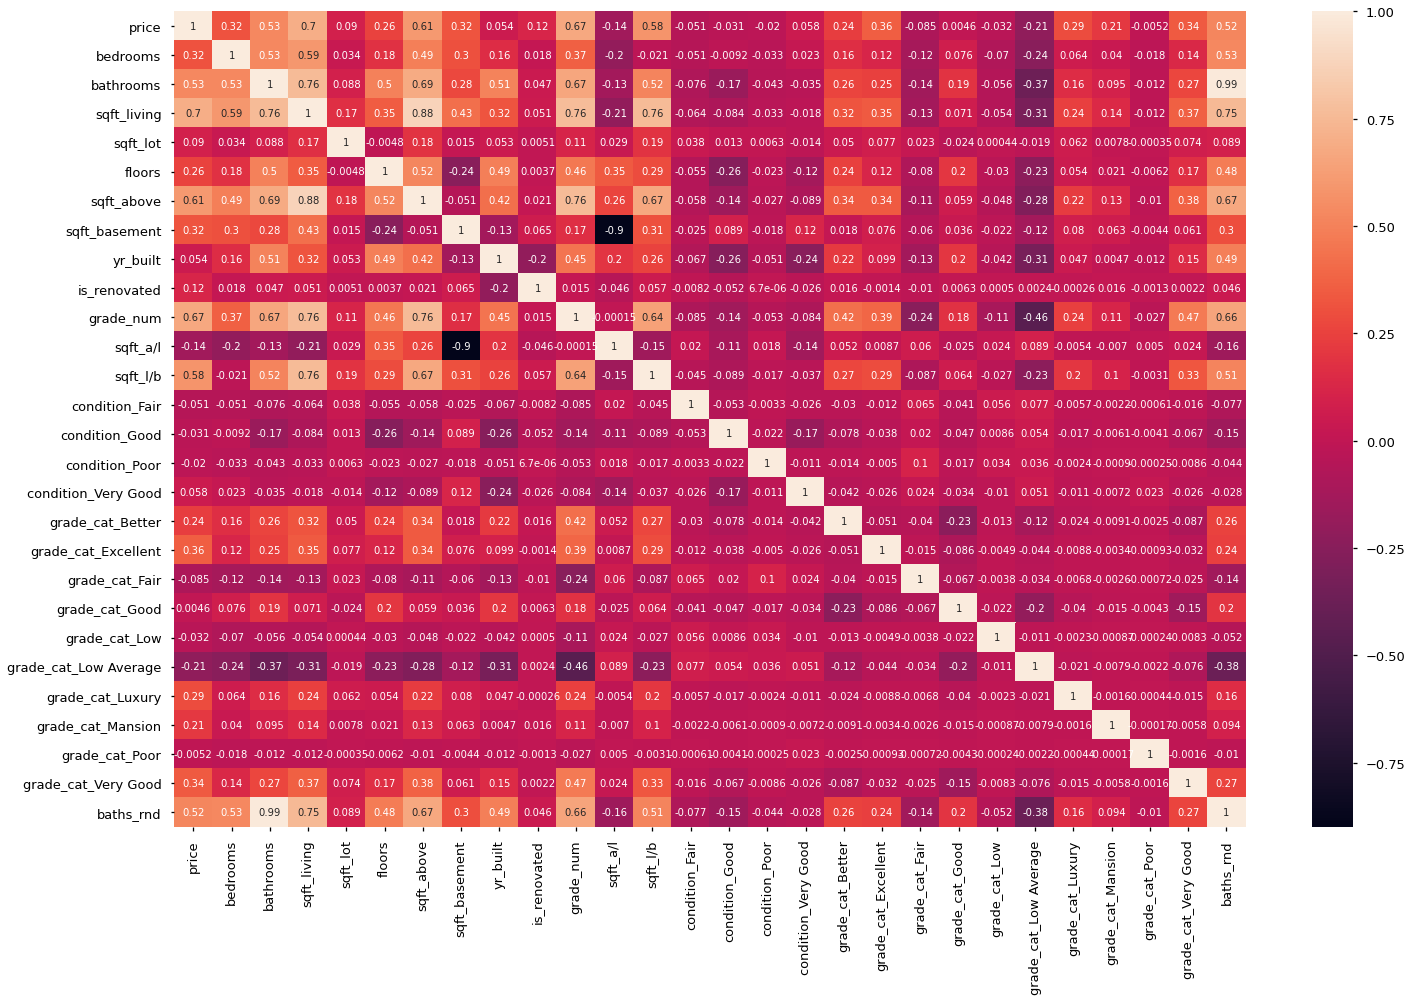

In [492]:
plt.figure(figsize = (24,15))
corrM = df_clean.corr()

sns.heatmap(corrM, annot=True)
plt.show()

## Regression Modeling

Realizing that I might have too many independent variables.  Going to start visualizing the data, and understanding what might have better performance vs those that do not.

# Notes

Figure out the range of grade?  What are the average ranges of each grade?

Remove outliers!

Remove p-values of > .05

qq plot
